In [1]:
import networkx as nx
import csv
import numpy as np
import glob
import os, os.path
import heapq
import networkit as nk
import random
import collections
from random import sample
import re
import math
import time
import networkx.algorithms.community as nxcom
from matplotlib import pyplot as plt
from collections import OrderedDict
from networkx.generators.community import LFR_benchmark_graph

In [2]:
#function that approximates the diameter of the graph
def approxVD(G):
    node_number = G.number_of_nodes()
    random_vertice = random.choice(list(G.nodes))
    shortest_paths = nx.single_source_shortest_path(G, random_vertice)
    ordered_index = sorted(shortest_paths, key = lambda key: len(shortest_paths[key]))
    last_index = ordered_index[len(ordered_index) - 1]
    last_index2 = ordered_index[len(ordered_index) - 2]
    max_shortest1 = shortest_paths.get(last_index)
    max_shortest2 = shortest_paths.get(last_index2)
    diameter = len(max_shortest1) + len(max_shortest2)
    return diameter

In [3]:
def bcApproxGen(G, epsilon=0.3, delta=0.5, universalConstant=0.5):
    bc = dict()
    edges = list(G.edges)
    for edge in edges:
        bc[edge] = 0
    vd = (approxVD(G))
    r = (universalConstant/(epsilon*epsilon)) * (math.log((vd-2),2) + math.log(1/delta))
    for i in range(round(r+1)):
        while True:
            sample_pair = sample(list(G.nodes()), 2)
            if (nx.has_path(G,sample_pair[0],sample_pair[1])):
                break
        shortest_paths = nx.all_shortest_paths(G, source = sample_pair[0], target = sample_pair[1])
        shortest_paths = list(shortest_paths)
        sample_path = random.choice(shortest_paths)
        prev = sample_path[0]
        for j in range(1,len(sample_path)):
            try:
                bc[(sample_path[j],prev)] += 1/r
            except:
                bc[(prev,sample_path[j])] += 1/r
            prev = sample_path[j]
    bc = dict(sorted(bc.items(), key=lambda item: item[1], reverse=True))
    filtered_list = list(bc)
    return filtered_list

In [4]:
#saijruulsan girvan
def _without_most_central_edges(G, most_valuable_edge, edge_number):
    original_num_components = nx.number_connected_components(G)
    num_new_components = original_num_components
    limit = round(math.sqrt(G.number_of_edges()))
    edges = most_valuable_edge(G)
    while num_new_components <= original_num_components:
        edges_to_rmv = edges[0:limit]
        while edges_to_rmv:
            edge = edges_to_rmv[0]
            G.remove_edge(*edges_to_rmv[0])
            if nx.number_connected_components(G) == 2:
                new_components = tuple(nx.connected_components(G))
                if len(new_components[0])<len(new_components[1]) and len(new_components[0])<round(math.sqrt(G.number_of_edges())):
                    G.add_edge(*edge)
                elif len(new_components[1])<=len(new_components[0]) and len(new_components[1])<round(math.sqrt(G.number_of_edges())):
                    G.add_edge(*edge)
                else:
                    break
            del edges_to_rmv[0]
        new_components = tuple(nx.connected_components(G))
        num_new_components = len(new_components)
        edges = most_valuable_edge(G)
    return new_components
def revised_girvan(G):
    if G.number_of_edges() == 0:
        yield tuple(nx.connected_components(G))
        return
    # If no function is provided for computing the most valuable edge,
    # use the edge betweenness centrality.
#     if most_valuable_edge is None:

    def most_valuable_edge(G):
        apprx = bcApproxGen(G)
        return apprx

    # The copy of G here must include the edge weight data.
    g = G.copy().to_undirected()
    # Self-loops must be removed because their removal has no effect on
    # the connected components of the graph.
    g.remove_edges_from(nx.selfloop_edges(g))
    edge_number = g.number_of_edges()
    while g.number_of_edges() > 0:
        yield _without_most_central_edges(g, most_valuable_edge, g.number_of_edges())

In [5]:
    #zurahad heregleh function
    def set_node_community(G, communities):
        '''Add community to node attributes'''
        for c, v_c in enumerate(communities):
            for v in v_c:
                # Add 1 to save 0 for external edges
                G.nodes[v]['community'] = c + 1
    def set_edge_community(G):
        '''Find internal edges and add their community to their attributes'''
        for v, w, in G.edges:
            if G.nodes[v]['community'] == G.nodes[w]['community']:
                # Internal edge, mark with community
                G.edges[v, w]['community'] = G.nodes[v]['community']
            else:
                # External edge, mark as 0
                G.edges[v, w]['community'] = 0
    def get_color(i, r_off=1, g_off=1, b_off=1):
        '''Assign a color to a vertex.'''
        r0, g0, b0 = 0, 0, 0
        n = 16
        low, high = 0.1, 0.9
        span = high - low
        r = low + span * (((i + r_off) * 3) % n) / (n - 1)
        g = low + span * (((i + g_off) * 5) % n) / (n - 1)
        b = low + span * (((i + b_off) * 7) % n) / (n - 1)
        return (r, g, b)

In [6]:
    #zurah function
    def draw_community(G, communities):
        plt.rcParams.update(plt.rcParamsDefault)
        plt.rcParams.update({'figure.figsize': (15, 10)})
        # Set node and edge communities
        set_node_community(G, communities)
        set_edge_community(G)
        # Set community color for nodes
        node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]
        # Set community color for internal edges
        external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
        internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]
        internal_color = [get_color(G.edges[e]['community']) for e in internal]
        pos = nx.spring_layout(network)
        # Draw external edges
        nx.draw_networkx(
        G, pos = pos, node_size=0,
        edgelist=external, edge_color="#333333", with_labels=False)
        # Draw nodes and internal edges
        nx.draw_networkx(
            G, pos= pos, node_color=node_color,
            edgelist=internal, edge_color=internal_color, with_labels=False)
        plt.show()

In [8]:
###################################################################
#revised on karate dataset
network = nx.karate_club_graph()
start_time1 = time.time()
result = revised_girvan(network)
communities = next(result)
print((time.time() - start_time1))

0.13065099716186523


In [81]:
communities

({0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 19, 21},
 {8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33})

In [14]:
###################################################################
#girvan on karate dataset
network = nx.karate_club_graph()
start_time1 = time.time()
result = nxcom.girvan_newman(network)
communities = next(result)
print((time.time() - start_time1))

0.0388948917388916


In [15]:
communities

({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21},
 {2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33})

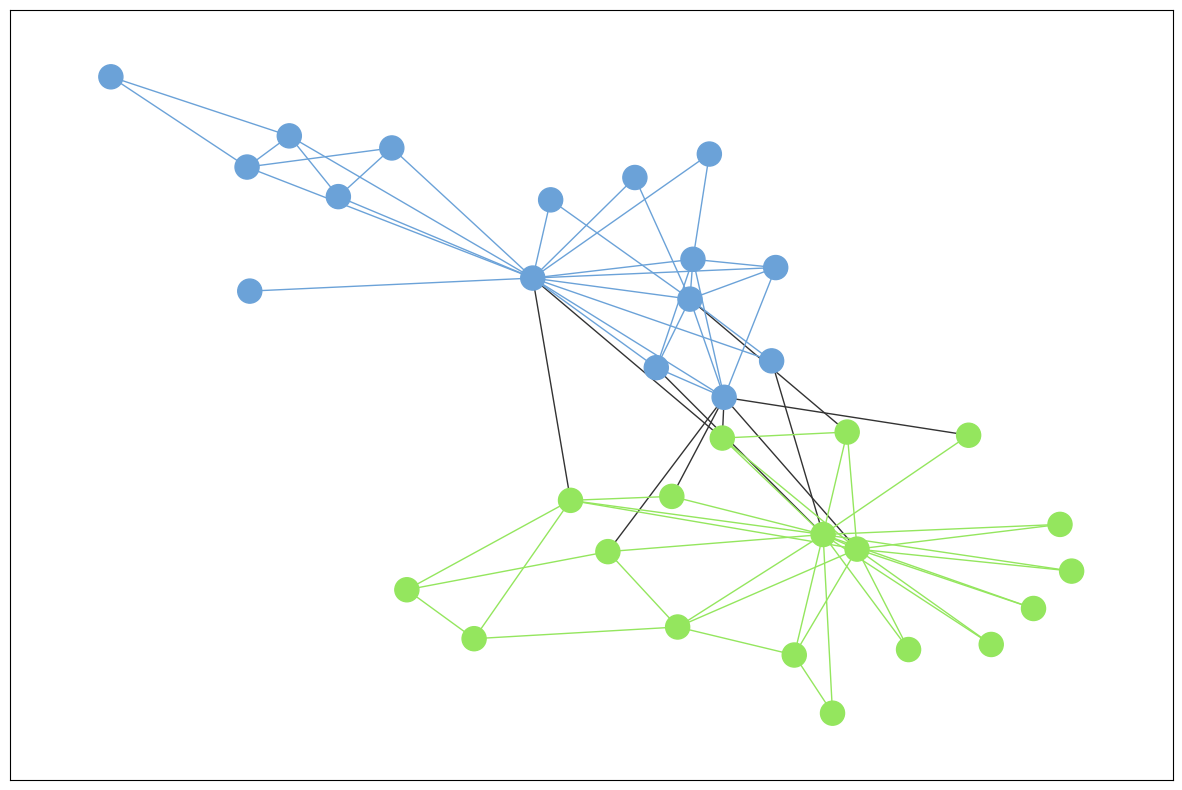

In [47]:
draw_community(network, communities)

In [238]:
###################################################################
#bc approx on fb food
edges = []
nodes = set()
with open('C:/Users/pc/Desktop/thesis/data/dataFoodFb/data.nodes', newline = '', encoding= 'utf-8') as data:                                                                                          
    reader = csv.reader(data, delimiter=',')
    for datum in data:
        datum = datum.split(",")
        index = len(datum) - 1
        datum[index] = datum[index].replace("\n", "")
        nodes.add(datum[index])
with open('C:/Users/pc/Desktop/thesis/data/dataFoodFb/data.edges', newline = '', encoding= 'utf-8') as data:                                                                                          
    reader = csv.reader(data, delimiter=',')
    for datum in data:
        datum = datum.split(",")
        datum[1] = datum[1].replace("\n", "")
        edges.append([datum[0], datum[1]])
network = nx.Graph()
network.add_nodes_from(nodes)
network.add_edges_from(edges)

In [174]:
network.number_of_edges()

2102

In [175]:
network.number_of_nodes()

620

In [245]:
###################################################################
#girvan on fb food
start_time2 = time.time()
result2 = nxcom.girvan_newman(network)
communities2 = next(result2)
print((time.time() - start_time2))

16.01320195198059


In [246]:
###################################################################
#revised on fb food
start_time1 = time.time()
result = revised_girvan(network)
communities = next(result)
print((time.time() - start_time1))

1.1629176139831543


In [229]:
len(communities[1])

118

In [231]:
len(communities2[1])

124

In [8]:
###################################################################
#bc approx on lastfm
edges = []
nodes = set()
with open('C:/Users/pc/Desktop/thesis/data/dataLastFm/data.csv', 'r') as f:
    reader = csv.reader(f)
    data = list(reader)

for datum in data:
    edges.append(datum)
    nodes.add(datum[0])
    nodes.add(datum[1])
network = nx.Graph()
network.add_nodes_from(nodes)
network.add_edges_from(edges)

In [10]:
###################################################################
#girvan on lastfm
start_time1 = time.time()
result = nxcom.girvan_newman(network)
communnities = next(result)
print((time.time() - start_time1))

KeyboardInterrupt: 

In [9]:
###################################################################
#revised on lastfm
start_time2 = time.time()
result2 = revised_girvan(network)
communnities2 = next(result2)
print((time.time() - start_time2))

59.24598574638367


In [247]:
sm=difflib.SequenceMatcher(None,list(communities[0]),list(communities2[0]))
sm.ratio()

0.9869608826479438

In [248]:
sm=difflib.SequenceMatcher(None,list(communities[1]),list(communities2[1]))
sm.ratio()

0.9794238683127572

In [515]:
###################################################################
#bc approx on wikipedia dataset
data = []
nodes = set()
with open('C:/Users/pc/Desktop/thesis/data/dataWiki/Wiki-Vote.txt', newline = '') as votes:                                                                                          
    vote_reader = csv.reader(votes, delimiter='\t')
    for vote in votes:
        datum = vote.split("\t")
        datum[1] = datum[1].replace("\r\n", "")
        nodes.add(datum[0])
        nodes.add(datum[1])
        data.append(datum)
network = nx.Graph()
network.add_nodes_from(nodes)
network.add_edges_from(data)


In [107]:
network.number_of_nodes()

7115

In [516]:
###################################################################
#revised on wiki
start_time1 = time.time()
result = revised_girvan(network)
communnities = next(result)
print((time.time() - start_time1))

19.965863943099976


In [517]:
###################################################################
#bc approx on advogato dataset
edges = []
nodes = set()
with open('C:/Users/pc/Desktop/thesis/data/dataAdvogato/data.edges', newline = '', encoding= 'utf-8') as data:                                                                                          
    reader = csv.reader(data, delimiter=' ')
    for datum in data:
        datum = datum.split(" ")
        nodes.add(datum[0])
        nodes.add(datum[1])
        edges.append([datum[0], datum[1]])
network = nx.Graph()
network.add_nodes_from(nodes)
network.add_edges_from(edges)

In [25]:
network.number_of_edges()

43427

In [518]:
###################################################################
#revised on advogato
start_time1 = time.time()
result = revised_girvan(network)
communnities = next(result)
print((time.time() - start_time1))

10.87993836402893


In [127]:
###################################################################
#bc approx on dolphine dataset
edges = []
nodes = set()
with open('C:/Users/pc/Desktop/thesis/data/dataDolphin/data.mtx', newline = '', encoding= 'utf-8') as data:                                                                                          
    reader = csv.reader(data, delimiter=',')
    for datum in data:
        datum = datum.split(" ")
        datum[1] = datum[1].replace("\n", "")
        nodes.add(datum[0])
        nodes.add(datum[1])
        edges.append([datum[0], datum[1]])
network = nx.Graph()
network.add_nodes_from(nodes)
network.add_edges_from(edges)

In [128]:
###################################################################
#revised on dolphine
start_time1 = time.time()
result = revised_girvan(network)
communities = next(result)
print((time.time() - start_time1))

0.12566423416137695


In [130]:
###################################################################
#girvan on dolphine
start_time1 = time.time()
result = nxcom.girvan_newman(network)
communities = next(result)
print((time.time() - start_time1))

0.08479976654052734


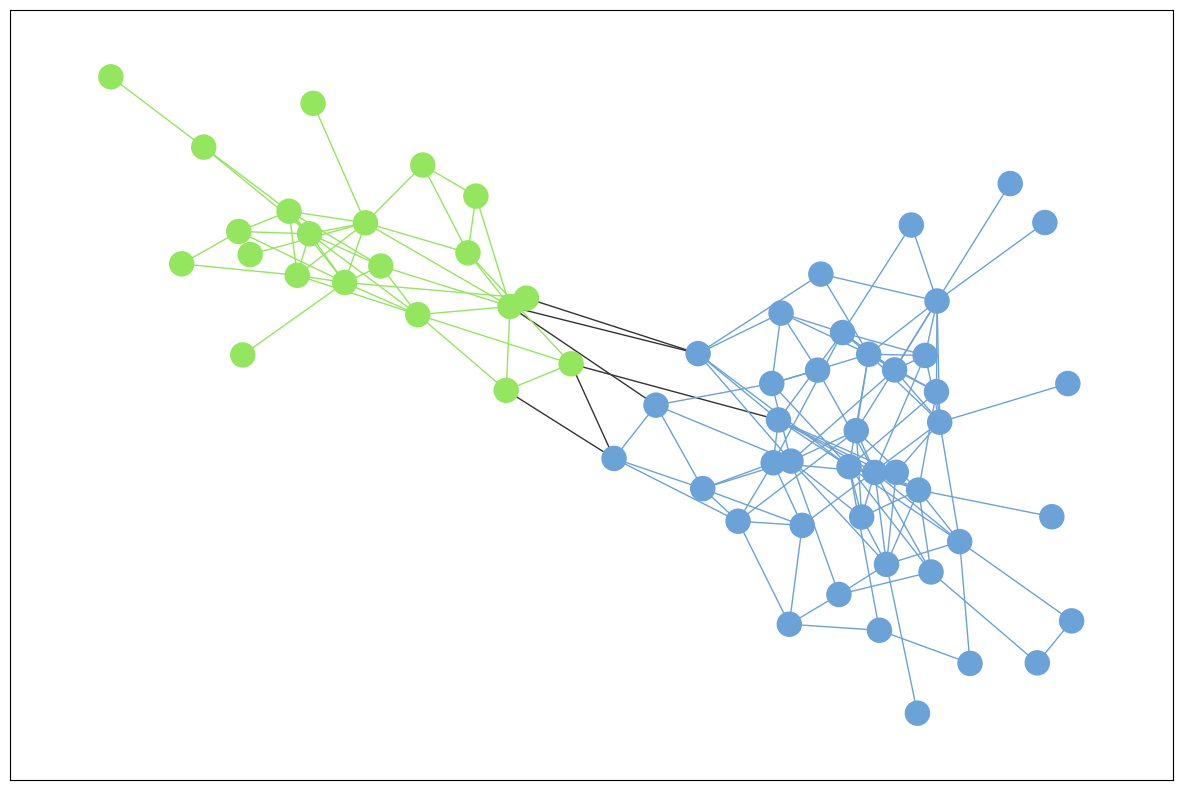

In [129]:
draw_community(network, communities)

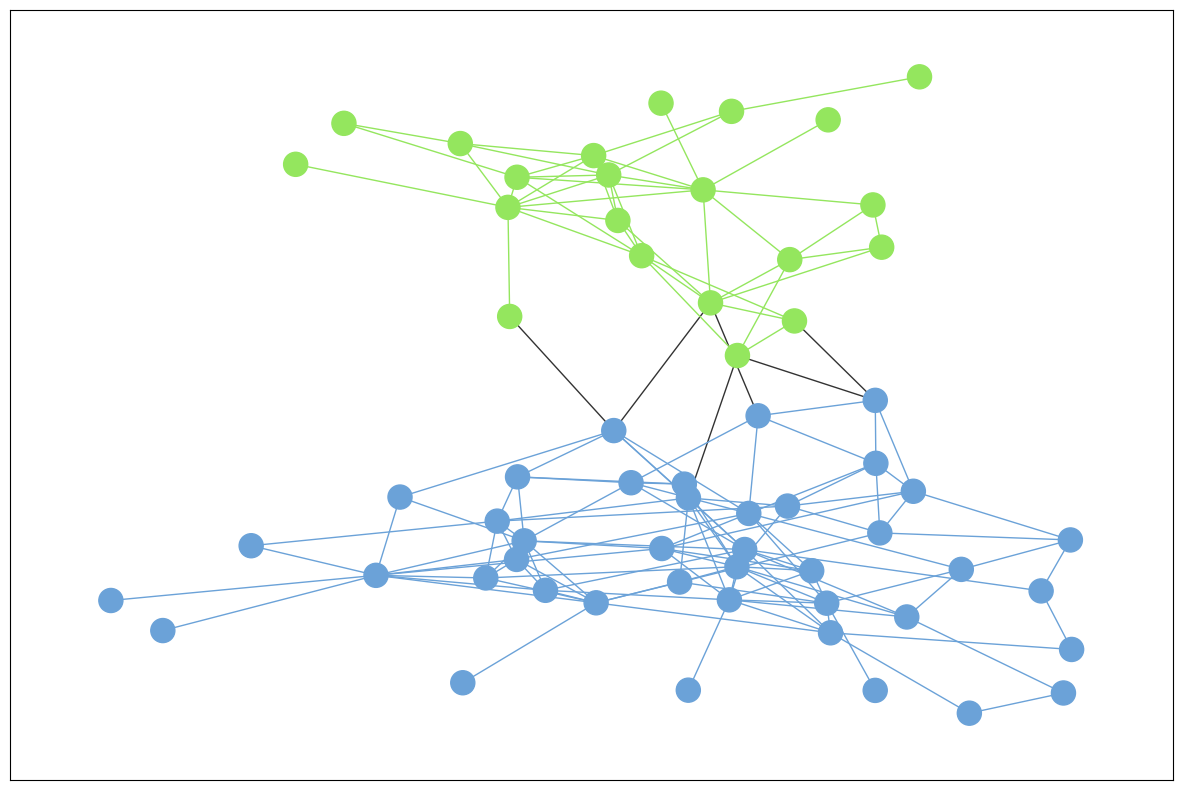

In [131]:
draw_community(network, communities)

In [9]:
#datagaa avah zamaa  zaana
pathhack = os.path.dirname(os.path.realpath("C:/Users/pc/Desktop/thesis/data/dataFb/feature_map.txt"))
feat_file_name = "%s/feature_map.txt" % (pathhack,)
feature_index = {}  #numeric index to name
inverted_feature_index = {} #name to numeric index
network = nx.Graph()
ego_nodes = []

#datagiin propertyg unshij avna
def load_features():
    # may need to build the index first
    if not os.path.exists(feat_file_name):
        feat_index = {}
        # build the index from data/*.featnames files
        featname_files = glob.iglob("%s/data/*.featnames" % (pathhack,))
        for featname_file_name in featname_files:
            featname_file = open(featname_file_name, 'r', encoding="utf8")
            for line in featname_file:
                # example line:
                # 0 birthday;anonymized feature 376
                index, name = parse_featname_line(line)
                feat_index[index] = name
            featname_file.close()
        keys = list(feat_index.keys())
        keys.sort()
        out = open(feat_file_name,'w')
        for key in keys:
            out.write("%d %s\n" % (key, feat_index[key]))
        out.close()
        
    # index built, read it in (even if we just built it by scanning)
    global feature_index
    global inverted_feature_index
    index_file = open(feat_file_name,'r')
    for line in index_file:
        split = line.strip().split(' ')
        key = int(split[0])
        val = split[1]
        feature_index[key] = val
    index_file.close()

    for key in feature_index.keys():
        val = feature_index[key]
        inverted_feature_index[val] = key

# # for fb
## line bolgonoos featuree yalgaj avna
def parse_featname_line(line):
    line = line[(line.find(' '))+1:]  # chop first field
    split = line.split(';')
    name = ';'.join(split[:-1]) # feature name
    index = int(split[-1].split(" ")[-1]) #feature index
    return index, name
#for twitter
# def parse_featname_line(line):
#     split = line.split()
#     index = int(split[0])
#     name = split[1]
#     return index, name

#oroiruudaa unshina
def load_nodes():
    assert len(feature_index) > 0, "call load_features() first"
    global network
    global ego_nodes
#     for x in glob.glob("%s/data/*.featnames" % (pathhack,)):
    #print(int(re.search(r'\d+', (x.split("/")[-1].split('.')[0])).group()))
    # get all the node ids by looking at the files
    ego_nodes = [int(re.search(r'\d+', (x.split("/")[-1].split('.')[0])).group()) for x in glob.glob("%s/data/*.featnames" % (pathhack,))]
    node_ids = ego_nodes

    # parse each node
    for node_id in node_ids:
        featname_file = open("%s/data/%d.featnames" % (pathhack,node_id), 'r', encoding="utf8")
        feat_file     = open("%s/data/%d.feat"      % (pathhack,node_id), 'r', encoding="utf8")
        egofeat_file  = open("%s/data/%d.egofeat"   % (pathhack,node_id), 'r', encoding="utf8")
        edge_file     = open("%s/data/%d.edges"     % (pathhack,node_id), 'r', encoding="utf8")

        # parse ego node
        network.add_node(node_id)
        # 0 1 0 0 0 ...
        ego_features = [int(x) for x in egofeat_file.readline().split(' ')]
        i = 0
        network.nodes[node_id]['features'] = np.zeros(len(feature_index))
        for line in featname_file:
            key, val = parse_featname_line(line)
            network.nodes[node_id]['features'][key] = ego_features[i] + 1
            i += 1

        # parse neighboring nodes
        for line in feat_file:
            featname_file.seek(0)
            split = [int(x) for x in line.split(' ')]
            node_id = split[0]
            features = split[1:]
            network.add_node(node_id)
            network.nodes[node_id]['features'] = np.zeros(len(feature_index))
            i = 0
            for line in featname_file:
                key, val = parse_featname_line(line)
                network.nodes[node_id]['features'][key] = features[i]
                i += 1
            
        featname_file.close()
        feat_file.close()
        egofeat_file.close()
        edge_file.close()

#irmeguudee unshina
def load_edges():
    global network
    assert network.order() > 0, "call load_nodes() first"
    edge_file = open("%s/facebook_combined.txt" % (pathhack,),"r")
    for line in edge_file:
        # nodefrom nodeto
        split = [int(x) for x in line.split(" ")]
        node_from = split[0]
        node_to = split[1]
        network.add_edge(node_from, node_to)

#niited ni graphaa unshij avah function
def load_network():
    """
    Load the network.  After calling this function, facebook.network points to a networkx object for the facebook data.
    """
    load_features()
    load_nodes()
    load_edges()

def feature_matrix():
    n_nodes = network.number_of_nodes()
    n_features = len(feature_index)

    X = np.zeros((n_nodes, n_features))
    for i,node in enumerate(network.nodes()):
        X[i,:] = network.node[node]['features']

    return X

def universal_feature(feature_index):
    """
    Does every node have this feature?
    """
    return len([x for x in network.nodes_iter() if network.node[x]['feautures'][feature_index] > 0]) // network.order() == 1


load_network()

In [10]:
###################################################################
#girvan on fb
start_time1 = time.time()
result = nxcom.girvan_newman(network)
communities = next(result)
print((time.time() - start_time1))

4306.294265270233


In [28]:
###################################################################
#revised on fb social
start_time2 = time.time()
result2 = revised_girvan(network)
for i in range(5):
    communities2 = next(result2)
print((time.time() - start_time2))

80.28912496566772


In [7]:
import difflib

In [23]:
sm=difflib.SequenceMatcher(None,list(communities[0]),list(communities2[0]))
sm.ratio()

0.9231633656412418

In [24]:
sm=difflib.SequenceMatcher(None,list(communities[1]),list(communities2[1]))
sm.ratio()

0.42961418143899893

In [346]:
network.number_of_edges()

88234

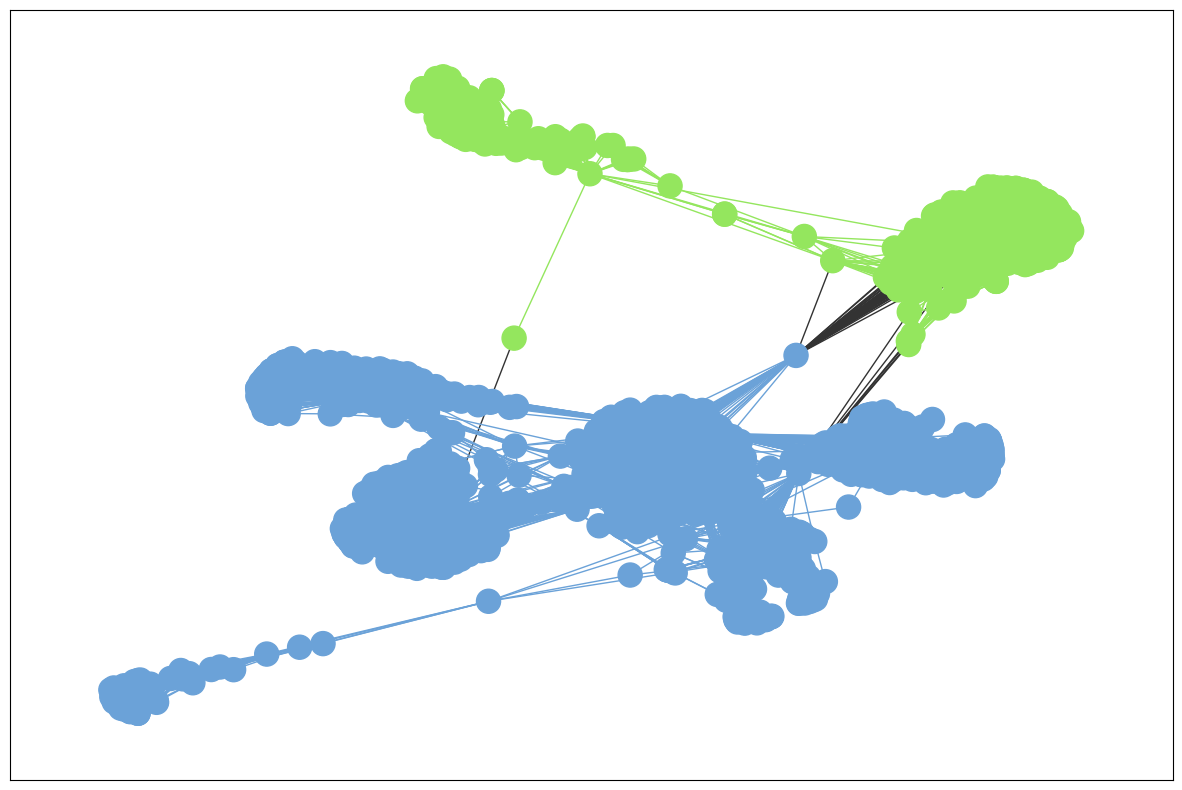

In [25]:
draw_community(network, communities2)

In [188]:
n = 30000
tau1 = 3
tau2 = 1.5
mu = 0.1
network = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=5, min_community=20, seed=10
)

In [185]:
start_time1 = time.time()
result = revised_girvan(network)
communities = next(result)
print((time.time() - start_time1))

0.5625886917114258


In [217]:
mus1 = []
exec_times1 = []
mu = 0.1
for i in range(59):
    n = 250
    tau1 = 3
    tau2 = 1.5
    network = LFR_benchmark_graph(
        n, tau1, tau2, mu, average_degree=5, min_community=20, seed=10
    )
    start_time1 = time.time()
    result = revised_girvan(network)
    communities = next(result)
    exec_time = (time.time() - start_time1)
    print(i)
    mus1.append(mu)
    exec_times1.append(exec_time)
    mu += 0.01

KeyboardInterrupt: 

In [186]:
mus2 = []
exec_times2 = []
mu = 0.1
for i in range(49):
    n = 3000
    tau1 = 3
    tau2 = 1.5
    network = LFR_benchmark_graph(
        n, tau1, tau2, mu, average_degree=5, min_community=20, seed=10
    )
    start_time1 = time.time()
    result = revised_girvan(network)
    communities = next(result)
    exec_time = (time.time() - start_time1)
    print(i)
    mus2.append(mu)
    exec_times2.append(exec_time)
    mu += 0.01

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


In [190]:
mus3 = []
exec_times3 = []
mu = 0.1
for i in range(49):
    n = 30000
    tau1 = 3
    tau2 = 1.5
    network = LFR_benchmark_graph(
        n, tau1, tau2, mu, average_degree=5, min_community=20, seed=10
    )
    start_time1 = time.time()
    result = revised_girvan(network)
    communities = next(result)
    exec_time = (time.time() - start_time1)
    print(i)
    mus3.append(mu)
    exec_times3.append(exec_time)
    mu += 0.01

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


In [196]:
mus4 = []
exec_times4 = []
mu = 0.1
for i in range(49):
    n = 15000
    tau1 = 3
    tau2 = 1.5
    network = LFR_benchmark_graph(
        n, tau1, tau2, mu, average_degree=5, min_community=20, seed=10
    )
    start_time1 = time.time()
    result = revised_girvan(network)
    communities = next(result)
    exec_time = (time.time() - start_time1)
    print(i)
    mus4.append(mu)
    exec_times4.append(exec_time)
    mu += 0.01

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


In [197]:
mus = []
exec_times = []
mus.append(mus1)
mus.append(mus2)
mus.append(mus3)
mus.append(mus4)
exec_times.append(exec_times1)
exec_times.append(exec_times2)
exec_times.append(exec_times3)
exec_times.append(exec_times4)

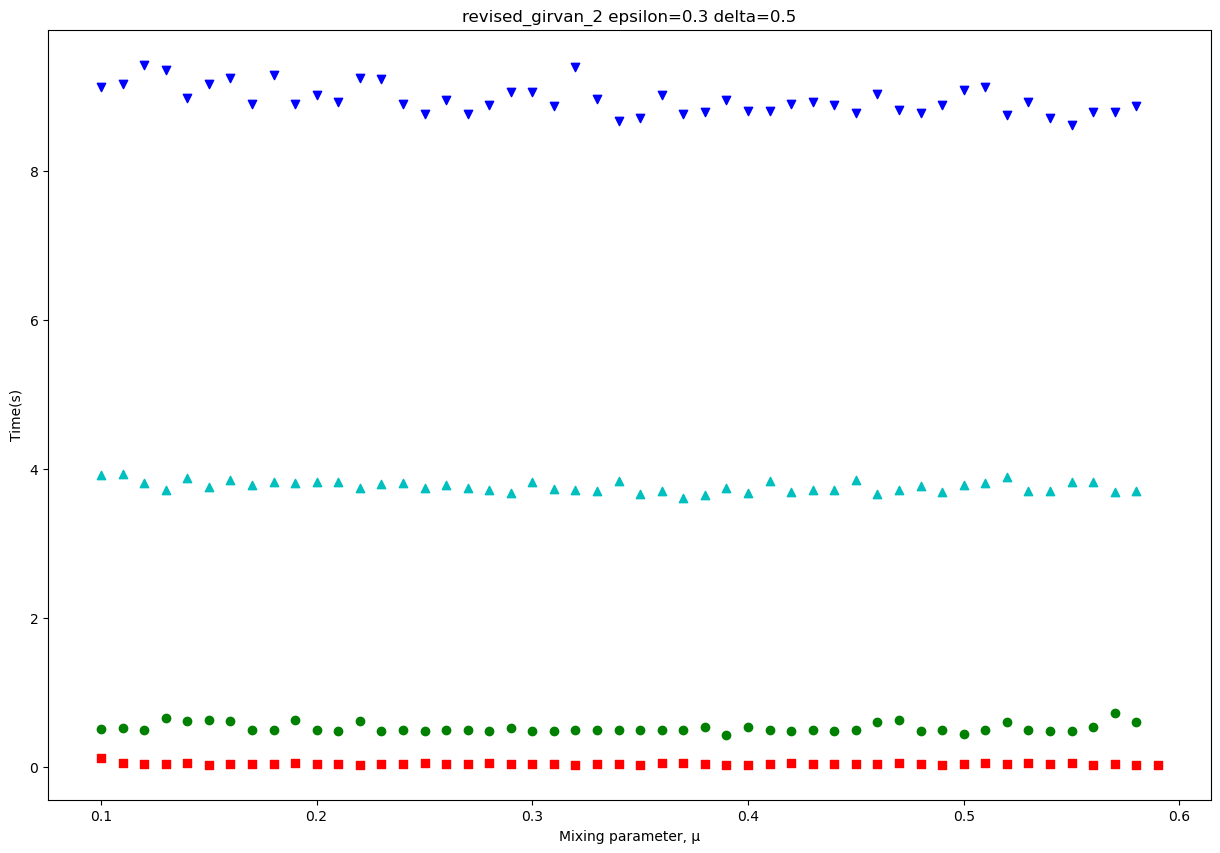

In [213]:
markers = ["," , "o"  , "v" ,"^"]
colors = ['r','g','b', "c"]

for i in range(4): #for each of the 7 features 
    mi = markers[i] #marker for ith feature 
    xi = mus[i]
    yi = exec_times[i]
    ci = colors[i] #color for ith feature 
    plt.title("revised_girvan_2 epsilon=0.3 delta=0.5")
    plt.xlabel("Mixing parameter, μ")
    plt.ylabel("Time(s)")
    plt.scatter(xi,yi,marker=mi, color=ci) 
plt.show() 

In [227]:
ns1 = []
exec_times1 = []
n = 250
for i in range(20):
    mu = 0.3
    tau1 = 3
    tau2 = 1.5
    network = LFR_benchmark_graph(
        n, tau1, tau2, mu, average_degree=5, min_community=50, seed=10
    )
    start_time1 = time.time()
    result = revised_girvan(network)
    communities = next(result)
    exec_time = (time.time() - start_time1)
    print(i)
    ns1.append(n)
    exec_times1.append(exec_time)
    n += 500

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [234]:
ns2 = []
exec_times2 = []
n = 250
for i in range(20):
    mu = 0.4
    tau1 = 3
    tau2 = 1.5
    network = LFR_benchmark_graph(
        n, tau1, tau2, mu, average_degree=5, min_community=50, seed=10
    )
    start_time1 = time.time()
    result = revised_girvan(network)
    communities = next(result)
    exec_time = (time.time() - start_time1)
    print(i)
    ns2.append(n)
    exec_times2.append(exec_time)
    n += 500

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [235]:
ns3 = []
exec_times3 = []
n = 250
for i in range(20):
    mu = 0.5
    tau1 = 3
    tau2 = 1.5
    network = LFR_benchmark_graph(
        n, tau1, tau2, mu, average_degree=5, min_community=50, seed=10
    )
    start_time1 = time.time()
    result = revised_girvan(network)
    communities = next(result)
    exec_time = (time.time() - start_time1)
    print(i)
    ns3.append(n)
    exec_times3.append(exec_time)
    n += 500

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [236]:
ns = []
exec_times = []
ns.append(ns1)
ns.append(ns2)
ns.append(ns3)
exec_times.append(exec_times1)
exec_times.append(exec_times2)
exec_times.append(exec_times3)

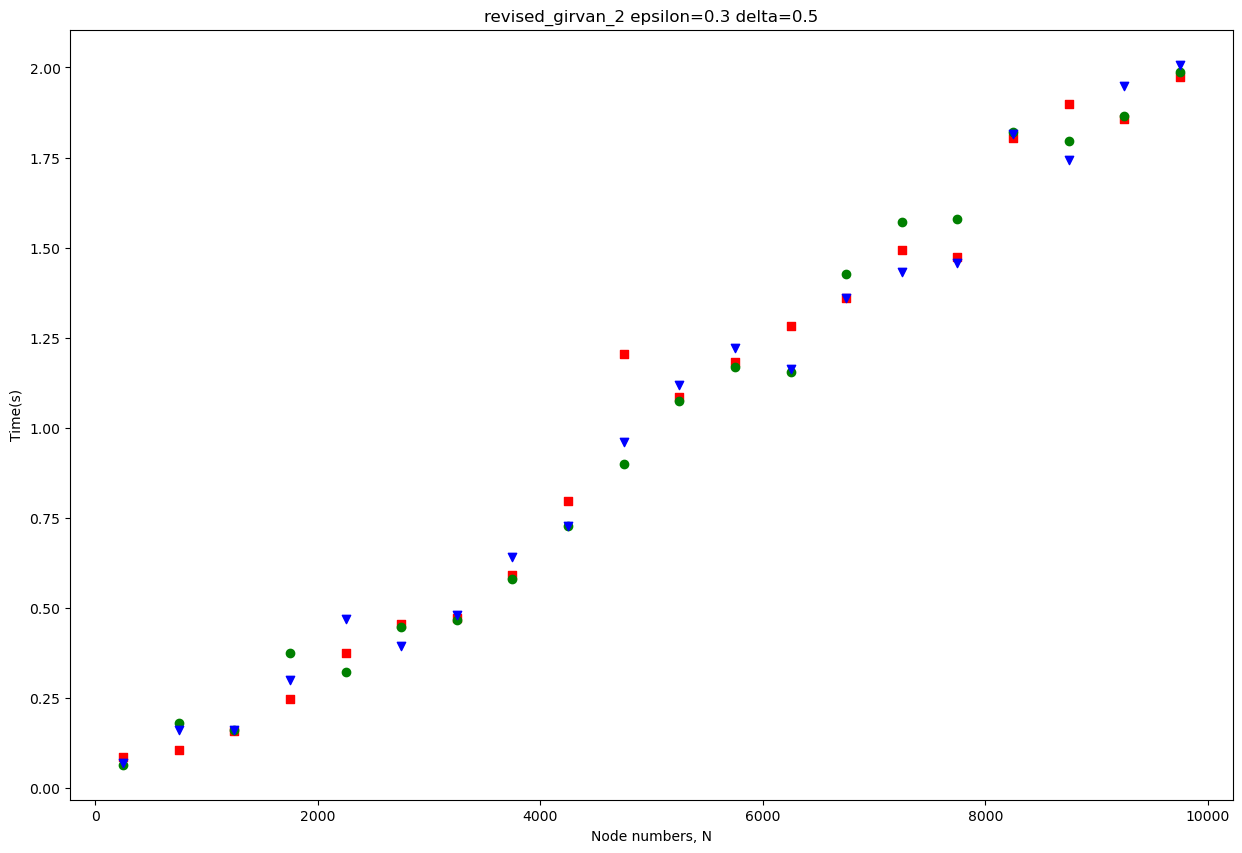

In [237]:
markers = ["," , "o"  , "v" ,"^"]
colors = ['r','g','b', "c"]

for i in range(3): #for each of the 7 features 
    mi = markers[i] #marker for ith feature 
    xi = ns[i]
    yi = exec_times[i]
    ci = colors[i] #color for ith feature 
    plt.title("revised_girvan_2 epsilon=0.3 delta=0.5")
    plt.xlabel("Node numbers, N")
    plt.ylabel("Time(s)")
    plt.scatter(xi,yi,marker=mi, color=ci) 
plt.show() 